# Об одной метрике эффективности алгломеративной кластеризации

Есть не так уж и много метрик эффективности кластеризации. Пожалуй, среди известных можно отметить только метрику силуэта. Поэтому есть смысл поразмышлять над этим и попробовать какие-то другие методы.

В этой работе мы разрабатываем собственную метрику эффективности кластризации, основанную на вычислении расстояний между центроидами кластеров.

Продробное изложение алгоритма читайте в [статье об этом исследовании](paper.pdf) в формате pdf.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.linear_model as skl
import sklearn.model_selection as sklm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

## Чтение данных

In [2]:
df = pd.read_csv('data/data.csv')
df

,Просмотры,Время просмотра (часы),Поделились,Постоянные зрители,Новые комментарии,Отказались от подписки,Новые подписчики,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,CTR для значков видео (%),Показы,Подписчики,Средний процент просмотра (%),Процент лайков,Средняя продолжительность просмотра,Дизлайки,Лайки
0,475.0,21.2038,9.0,84.0,0.0,5.0,5.0,144.0,2.0833,228.0,4.25,5176.0,0.0,30.51,100.00,160.702484,0.0,16.0
1,174.0,5.4814,1.0,48.0,0.0,1.0,1.0,60.0,1.6111,108.0,4.05,2222.0,0.0,19.52,100.00,113.408276,0.0,4.0
2,490.0,17.8182,3.0,94.0,0.0,1.0,1.0,133.0,2.1586,227.0,5.27,5584.0,0.0,23.51,75.00,130.909224,1.0,3.0
3,665.0,25.9174,10.0,128.0,1.0,2.0,1.0,231.0,1.8524,359.0,5.78,6759.0,-1.0,25.35,100.00,140.304722,0.0,8.0
4,971.0,35.3850,4.0,166.0,0.0,3.0,7.0,362.0,1.8390,528.0,7.04,6736.0,4.0,21.72,85.71,131.190525,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,287.0,16.8233,0.0,55.0,0.0,0.0,4.0,97.0,1.8882,152.0,3.99,3156.0,4.0,41.29,90.91,211.023972,1.0,10.0
496,310.0,17.3132,0.0,47.0,0.0,4.0,4.0,89.0,2.2794,136.0,3.99,4359.0,0.0,40.61,85.71,201.056516,1.0,6.0
497,275.0,10.4130,1.0,44.0,0.0,1.0,4.0,63.0,2.5701,107.0,4.00,4176.0,3.0,26.91,100.00,136.315636,0.0,2.0
498,222.0,10.5967,0.0,46.0,1.0,2.0,3.0,69.0,1.9304,115.0,4.03,2976.0,1.0,33.30,66.67,171.838378,2.0,4.0


## Вложенный цикл

Мы прогоним вложенный цикл:

1. Внешний по числу процентов, которые мы отводим на тестовую выборку (от 10 до 90 с шагом 10)
2. Вложенный по числу кластеров
3. По случайным запускам, где каждый раз происходит новое разбиение на train и test (эти запуски усредняются, чтобы нивелировать случайности)

Фактически, весь алгоритм здесь представлен в одной ячейке. Все остальное носит декоративный храктер.

доля теста = 0.1


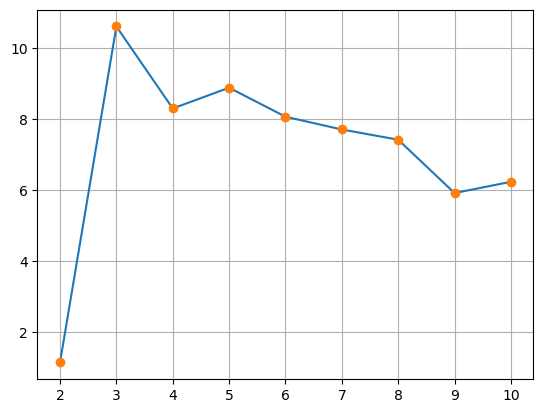


доля теста = 0.2


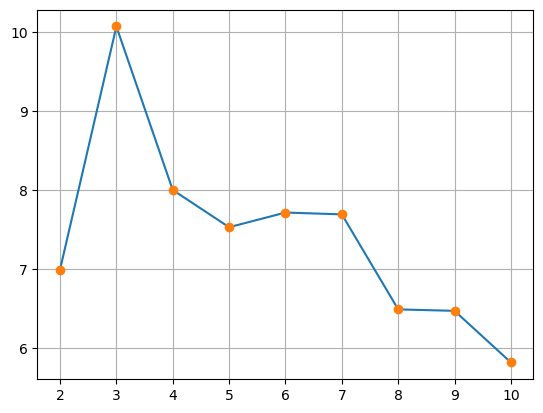


доля теста = 0.30000000000000004


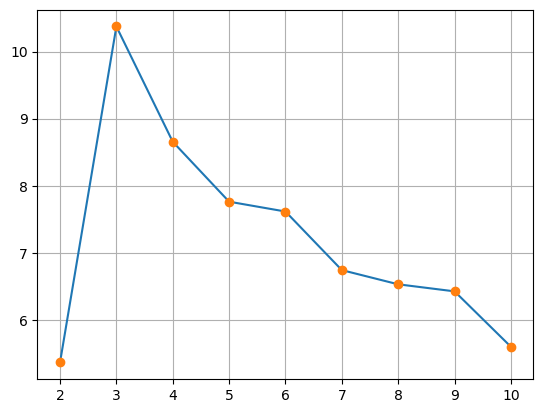


доля теста = 0.4


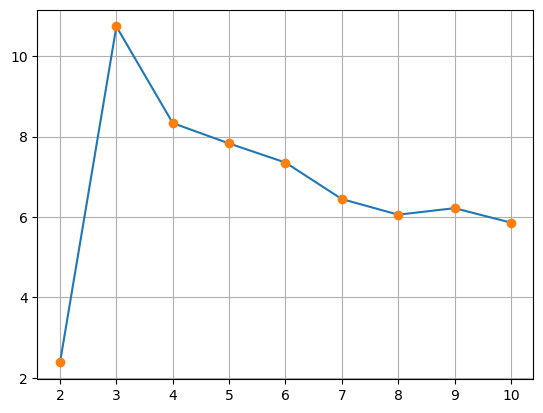


доля теста = 0.5


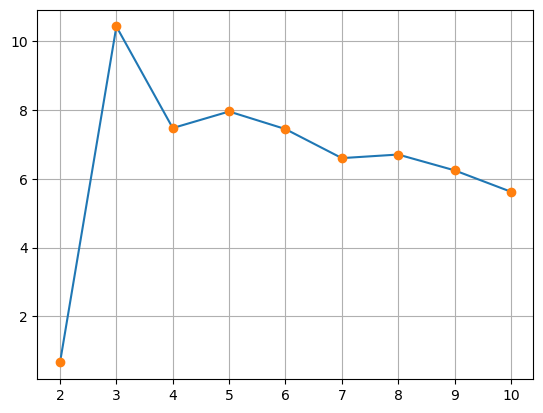


доля теста = 0.6000000000000001


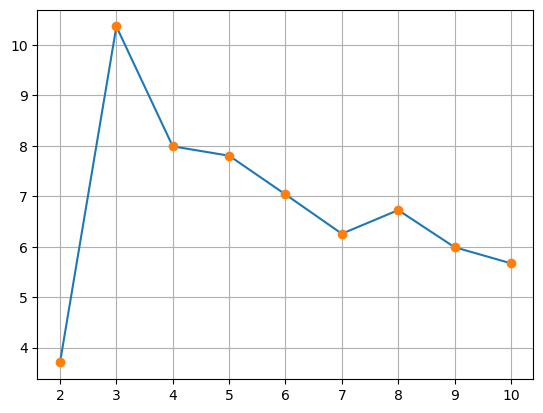


доля теста = 0.7000000000000001


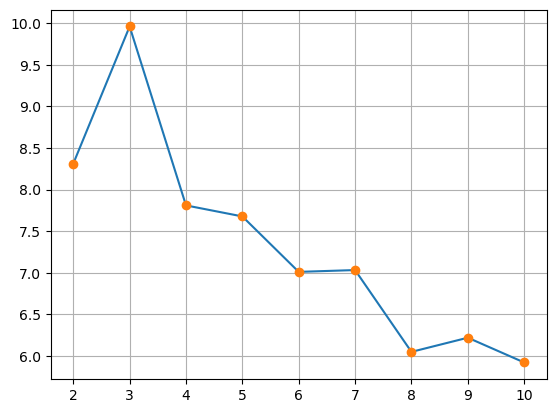


доля теста = 0.8


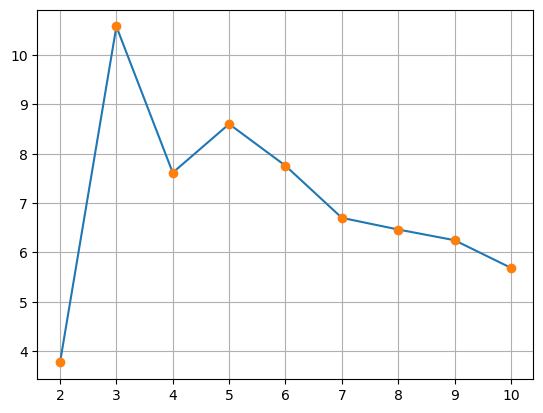


доля теста = 0.9


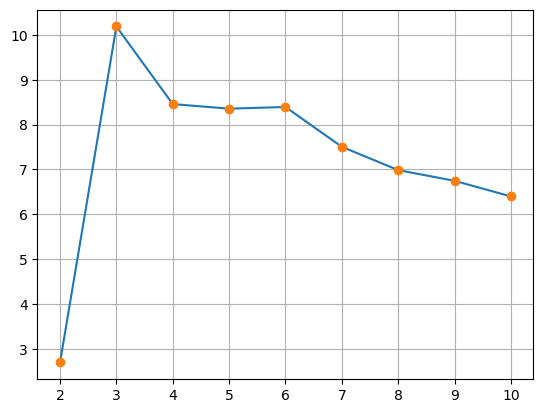

In [3]:
# В этот датафрейм будем записывать результаты. Получится сводная таблица, на основании которой будем делать выводы
df_results = pd.DataFrame(columns = np.arange(1, 10)*10)

# Нормализация данных

df = (df - df.mean())/df.std() 

# Внешний цикл по проценту test'а
for pro in range(1,10):
    
    # Dataframe Raw -- строки датафрейма с результатами. Пустой список, потом мы будем его заполнять
    DR = []

    # Вложенный цикл по числу кластеров
    for k in range(2, 11):

        # Сюда будем записывать средние дистанции
        dist_mean_list = []

        for a in range(10):

            # Разбиение данных на обучающую и тестовую выборки
            df_train, df_test = sklm.train_test_split(df, test_size = 0.1* pro)

            # Преобразование данных в массивы numpy
            X_train = df_train.to_numpy()
            X_test = df_test.to_numpy()

            # Агломеративная кластеризация
            clust_train = AgglomerativeClustering(n_clusters = k)
            clust_train.fit(X_train)
            labels_train = clust_train.labels_

            clust_test = AgglomerativeClustering(n_clusters = k)
            clust_test.fit(X_test)
            labels_test = clust_test.labels_

            # Вычисление центроидов
            df_train['labels'] = labels_train
            df_test['labels'] = labels_test

            df_c_train = pd.DataFrame(columns = df.columns, index = df_train['labels'].unique())

            for label in df_train['labels'].unique():
                d = df_train.loc[df_train['labels'] == label]
                centroid = d.drop(columns = ['labels']).mean()
                df_c_train.iloc[label] = centroid

            df_c_test= pd.DataFrame(columns = df.columns, index = df_test['labels'].unique())

            for label in df_test['labels'].unique():
                d = df_test.loc[df_test['labels'] == label]
                centroid = d.drop(columns = ['labels']).mean()
                df_c_test.iloc[label] = centroid

            df_c_train = df_c_train.reset_index().drop(columns = ['index'])
            df_c_test = df_c_test.reset_index().drop(columns = ['index'])

            # Вычисление дистанций между ближайшими центроидами
            dist_list = []

            for i in range(len(df_c_train)):

                # Поиск ближайших соседей
                knn = NearestNeighbors(n_neighbors=1)
                knn.fit(df_c_train)
                dist, ind = knn.kneighbors(df_c_test)

                # Пополнение списка дистанций.
                dist_list.append(dist.min())

                # Удаление ближайших соседей. 
                df_c_test = df_c_test.drop(index = list(dist).index(dist.min())).reset_index().drop(columns = 'index')
                df_c_train = df_c_train.drop(index = ind[list(dist).index(dist.min())]).reset_index().drop(columns = 'index')

            # Вычисление средней дистанции между центроидами
            dist_mean = np.array(dist_list).mean()
            dist_mean_list.append(dist_mean)
        
        # Усреднение
        dist_mean_repeat = np.array(dist_mean_list).sum()/len(dist_mean_list)
        
        # Пополнение строки результата
        DR.append(dist_mean_repeat)
    
    # Картинка
    print('доля теста =', 0.1* pro)
    plt.grid()

    plt.plot(np.arange(2, 11), np.array(DR), '-')
    plt.plot(np.arange(2, 11), np.array(DR), 'o')

    plt.show()
    
    print('')
    
    # Добавление последней строки в сводную  таблицу результатов
    df_results.loc[len(df_results)] = np.array(DR)

## Результаты

In [4]:
# Сводная таблица результатов. Правда, индексы должны идти от 2, а не от 0, но это мелочь
df_results

,10,20,30,40,50,60,70,80,90
0,1.152652,10.607679,8.300936,8.884371,8.068459,7.708820,7.421188,5.920376,6.236907
1,6.996325,10.069803,8.003000,7.532628,7.718023,7.694907,6.493942,6.475378,5.822833
2,5.364173,10.374504,8.655661,7.761800,7.615019,6.741543,6.529738,6.424642,5.598512
3,2.385439,10.733672,8.333673,7.827174,7.352831,6.445491,6.057206,6.219322,5.860169
4,0.655716,10.429939,7.474837,7.956808,7.445075,6.600584,6.704651,6.244970,5.622413
5,3.703470,10.367236,7.989863,7.804431,7.036037,6.256652,6.725649,5.989672,5.670362
6,8.311277,9.958997,7.810052,7.677627,7.011694,7.033479,6.050893,6.221120,5.923565
7,3.770121,10.580602,7.617391,8.603699,7.757918,6.701947,6.465193,6.248439,5.688217
8,2.700603,10.185087,8.456005,8.354365,8.391770,7.504620,6.986020,6.746916,6.399557


In [5]:
# Поскольку цикл долго считатеся, выводим сводную таблицу во внешний файл, 
# чтобы не гонять цикл заново, если возникнет необходимость снова обратиться к результату
df_results.to_csv('data/results.csv', index = False)

## Анализ результатов

Проще всего посмотреть на картинки. В [статье](paper.pdf) мы именно так и делаем. 

1. Видим, что оптимальное число кластеров для разбиения равно  2, и это, кстати, полностью согласуется с результатами нашего исследования метрики А. Буркова на основе матриц принадлежности, которое описано в [другой статье](https://github.com/vladimir-mosin/n-clusters/blob/main/paper.pdf).
2. А оптимальное разбиение данных на test и train это 50 на 50 (тоже хорошо согласуется с вышеуказанным методом, там получалось 40 на 60).

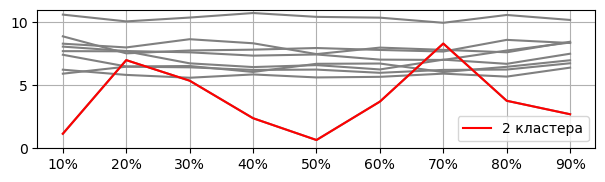

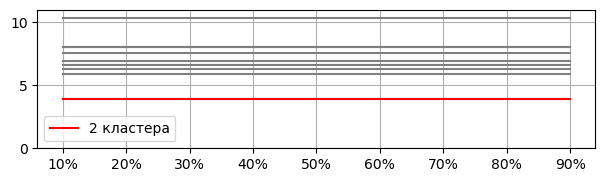

In [12]:
# Картинки, разумеется, не воспроизводят иллюстрации в статье. 
# Потому что случайные разбиения на train и test играют свою роль.
# Вдобавок здесь мы делаем только 10 запусков, а там делали 100ю
# Но общий результат все равно тоот же: кластров -- 2, соотношение -- 50 на 50

ddd = df_results

cols = df_results.columns

plt.figure(figsize = (7.2, 1.8))


plt.ylim([0, 11])
plt.xticks(np.arange(10, 100, 10), ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])

plt.grid()

for i in range(len(cols)):
    plt.plot(np.arange(10, 100, 10), ddd[cols[i]].to_numpy(), '-', color = 'grey')

plt.plot(np.arange(10, 100, 10), ddd[cols[0]].to_numpy(), '-', color = 'red', label = '2 кластера')

plt.legend()

#plt.savefig('Проценты-дистанция.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()


cols = ddd.columns

plt.figure(figsize = (7.2, 1.8))


plt.ylim([0, 11])
plt.xticks(np.arange(10, 100, 10), ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])

plt.grid()

for i in range(len(cols)):
    plt.plot(np.arange(10, 100, 10), [ddd[cols[i]].to_numpy().mean()]*(len(np.arange(10, 100, 10))), '-', color = 'grey')

plt.plot(np.arange(10, 100, 10), [ddd[cols[0]].to_numpy().mean()]*(len(np.arange(10, 100, 10))), '-', color = 'red', label = '2 кластера')

plt.legend()

#plt.savefig('Проценты-дистанция. Средние.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

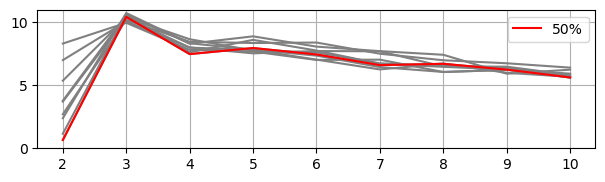

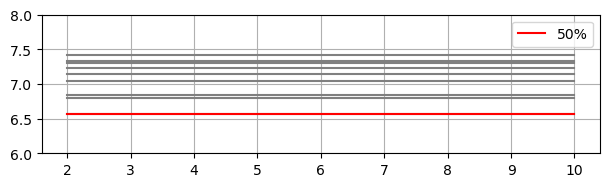

In [8]:
cols = ddd.columns

plt.figure(figsize = (7.2, 1.8))

plt.ylim([0, 11])

plt.grid()

for i in range(len(cols)):
    plt.plot(np.arange(2, 11), ddd.iloc[i].to_numpy(), '-', color = 'grey')

plt.plot(np.arange(2, 11), ddd.iloc[4].to_numpy(), '-', color = 'red', label='50%')


plt.legend()

#plt.savefig('Кластеры-дистанция.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()


cols = ddd.columns

plt.figure(figsize = (7.2, 1.8))

plt.grid()
plt.ylim((6, 8))
for i in range(len(cols)):
    plt.plot(np.arange(2, 11), [ddd.iloc[i].to_numpy().mean()]*len(cols), '-', color = 'grey')
    
plt.plot(np.arange(2, 11), [ddd.iloc[4].to_numpy().mean()]*len(cols), '-', color = 'red', label='50%')
plt.legend()
#plt.savefig('Кластеры-дистанция. Средние.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()